<font size="6">Enefit - Predict Energy Behavior of Prosumers</font>

<font size="4">Predict Prosumer Energy Patterns and Minimize Imbalance Costs.</font>

https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers

# 1. Overview

The goal of the competition is to create an energy prediction model of prosumers to reduce energy imbalance costs. This competition aims to tackle the issue of energy imbalance, a situation where the energy expected to be used doesn't line up with the actual energy used or produced. Prosumers, who both consume and generate energy, contribute a large part of the energy imbalance. Despite being only a small part of all consumers, their unpredictable energy use causes logistical and financial problems for the energy companies.

- **Description**

The number of prosumers is rapidly increasing, and solving the problems of energy imbalance and their rising costs is vital. If left unaddressed, this could lead to increased operational costs, potential grid instability, and inefficient use of energy resources. If this problem were effectively solved, it would significantly reduce the imbalance costs, improve the reliability of the grid, and make the integration of prosumers into the energy system more efficient and sustainable. Moreover, it could potentially incentivize more consumers to become prosumers, knowing that their energy behavior can be adequately managed, thus promoting renewable energy production and use.

- **About us**

Enefit is one of the biggest energy companies in Baltic region. As experts in the field of energy, we help customers plan their green journey in a personal and flexible manner as well as implement it by using environmentally friendly energy solutions.

At present, Enefit is attempting to solve the imbalance problem by developing internal predictive models and relying on third-party forecasts. However, these methods have proven to be insufficient due to their low accuracy in forecasting the energy behavior of prosumers. The shortcomings of these current methods lie in their inability to accurately account for the wide range of variables that influence prosumer behavior, leading to high imbalance costs. By opening up the challenge to the world's best data scientists through the Kaggle platform, Enefit aims to leverage a broader pool of expertise and novel approaches to improve the accuracy of these predictions and consequently reduce the imbalance and associated costs.

- **Evaluation**

Submissions are evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:
$$
MAE = \frac{1}{n} \sum_{i=1}^{n}{|y_i-x_i|}
$$

- **Timeline**

This is a future data prediction competition with an active training phase and a second period where selected submissions will be evaluated against future ground truth data.

**Training Timeline**

- November 1, 2023 - Start Date.

- January 24, 2024 - Entry Deadline. You must accept the competition rules before this date in order to compete.

- January 24, 2024 - Team Merger Deadline. This is the last day participants may join or merge teams.

- January 31, 2024 - Final Submission Deadline.

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

**Prediction Timeline**

Starting after the final submission deadline there will be periodic updates to the leaderboard to reflect future data updates that will be evaluated against selected submissions. We anticipate 1-3 updates before the final evaluation.

- April 30, 2024 - Competition End Date.

# 2. Import

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import seaborn as sns
import colorcet as cc
import squarify

import plotly.express as px

In [2]:
train_df = pd.read_csv("train.csv")
county_id_to_name_map = pd.read_json(
    "county_id_to_name_map.json",
    typ="series",
).str.capitalize()

In [3]:
# sns.set()

RAND = 10

PALETTE = sns.color_palette(cc.glasbey, n_colors=16)
# n_colors=df.county.nunique()

# 3. EDA

Dataset Description
Your challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

This is a forecasting competition using the time series API. The private leaderboard will be determined using real data gathered after the submission period closes.

💡 Nota bene:

All datasets follow the same time convention. Time is given in EET/EEST. Most of the variables are a sum or an average over a period of 1 hour. The datetime column (whatever its name) always gives the start of the 1-hour period. However, for the weather datasets, some variables such as temperature or cloud cover, are given for a specific time, which is always the end of the 1-hour period.

## 1. train.csv

### Description
- county - An ID code for the county.
- is_business - Boolean for whether or not the prosumer is a business.
- product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- is_consumption - Boolean for whether or not this row's target is consumption or production.
- datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- row_id - A unique identifier for the row.
- prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. *New prediction units can appear or disappear in the test set*.

### General

In [4]:
df = train_df.copy()
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   county              2018352 non-null  int64  
 1   is_business         2018352 non-null  int64  
 2   product_type        2018352 non-null  int64  
 3   target              2017824 non-null  float64
 4   is_consumption      2018352 non-null  int64  
 5   datetime            2018352 non-null  object 
 6   data_block_id       2018352 non-null  int64  
 7   row_id              2018352 non-null  int64  
 8   prediction_unit_id  2018352 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [6]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2018352.00,2018352.00,2018352.00,2017824.00,2018352.00,2018352.00,2018352.00,2018352.00
mean,7.30,0.54,1.90,274.86,0.50,321.87,1009175.50,33.05
std,4.78,0.50,1.08,909.50,0.50,182.63,582648.18,19.59
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,0.00,1.00,0.38,0.00,166.00,504587.75,16.00
50%,7.00,1.00,2.00,31.13,0.50,323.00,1009175.50,33.00
75%,11.00,1.00,3.00,180.21,1.00,479.00,1513763.25,50.00
max,15.00,1.00,3.00,15480.27,1.00,637.00,2018351.00,68.00


In [7]:
df.describe(include='object')

,datetime
count,2018352
unique,15312
top,2022-11-27 12:00:00
freq,138


In [8]:
# Renaming to avoid confusion and improve readability

values_mapper = {
    "county": county_id_to_name_map,
    "is_business": {
        0: "not_business",
        1: "business"
    },
    "is_consumption": {
        0: "production",
        1: "consumption"
    },
    "product_type": {
        0: "Combined",
        1: "Fixed",
        2: "General service",
        3: "Spot",
    },
}

In [9]:
for column in values_mapper:
    df[column] = df[column].map(values_mapper[column])

df = df.astype({
    "county": "category",
    "is_business": "category",
    "product_type": "category",
    "is_consumption": "category",
    "datetime": "datetime64[ns]",
})

In [10]:
# df = df.astype({
#     "county": "uint8",
#     "is_business": "bool",
#     "product_type": "uint8",
#     "is_consumption": "bool",
#     "datetime": "datetime64[ns]",})

### Missing values and duplicates

In [11]:
df.isna().sum()[df.isna().sum() != 0]

target    528
dtype: int64

In [12]:
df.duplicated().sum()

0

- There are a small amount (528/2018352 < 0.1%) of missing values and zero duplicates in the dataframe.
- Only target column has missing values.

In [13]:
df[df.isna().any(axis=1)].head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
178938,Harjumaa,not_business,Fixed,NaN,production,2021-10-31 03:00:00,60,178938,0
178939,Harjumaa,not_business,Fixed,NaN,consumption,2021-10-31 03:00:00,60,178939,0
178940,Harjumaa,not_business,General service,NaN,production,2021-10-31 03:00:00,60,178940,1
178941,Harjumaa,not_business,General service,NaN,consumption,2021-10-31 03:00:00,60,178941,1
178942,Harjumaa,not_business,Spot,NaN,production,2021-10-31 03:00:00,60,178942,2


In [14]:
na_datetimes = df[df.isna().any(axis=1)].datetime.unique()
na_datetimes

<DatetimeArray>
['2021-10-31 03:00:00', '2022-03-27 03:00:00', '2022-10-30 03:00:00',
 '2023-03-26 03:00:00']
Length: 4, dtype: datetime64[ns]

- All missing values correspond to the first/last hours of DST.

In [15]:
df.loc[df['datetime'].isin(na_datetimes), ['target']].shape

(528, 1)

- All target values at these timestamps are missing.

## Target distribution

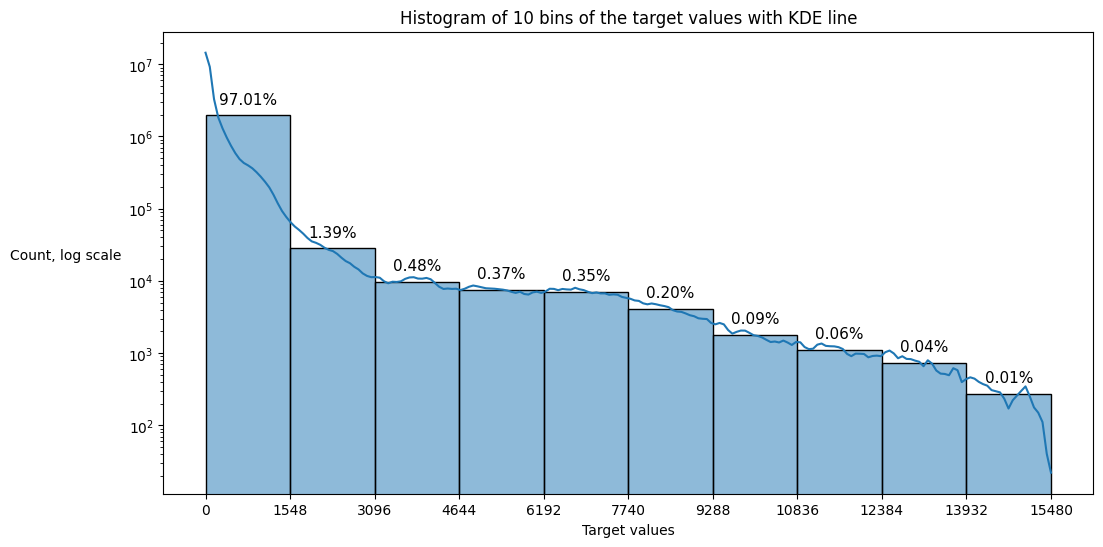

In [64]:
# Creating target's discrete intervals
bins = 10
plt.figure(figsize=(12, 6))

target_bins_percentage = round(
    pd
    .cut(np.array(df.target), bins, precision=0)
    .value_counts()
    / df.shape[0]
    * 100,
    2)

# Re-calculate first value so
# that the sum of the percentages is equal to 100.0
target_bins_percentage[0] = 100 - target_bins_percentage[1:].sum()
target_bins_percentage = [f"{i:.2f}%" for i in target_bins_percentage]

data_max = df.target.max()
ticks = range(0, int(data_max) + 1, int(data_max / bins))

ax = sns.histplot(df.target, bins=bins, kde=True)

# Adding group percentage to the top of each bar
# for ix, patch in enumerate(ax.patches):
#     ax.annotate(
#         text=target_bins_percentage[ix],
#         xy=(patch.get_x() + patch.get_width() / 2, ax.get_ylim()[1]),
#         horizontalalignment="center",
#     )
ax.bar_label(ax.containers[0], target_bins_percentage, padding=6, fontsize=11)

plt.title('Histogram of 10 bins of the target values with KDE line')
plt.xticks(ticks=ticks, rotation=0)
plt.xlabel("Target values")

# Using a logarithmic scale for the y-axis for better visualization
# of small quantities of target values
plt.yscale("log")
plt.ylabel("Count, log scale", rotation=0, labelpad=45)
plt.show()

- Target distribution is not normal, it's right-skewed.

In [91]:
# data = df.dropna()  #.sample(10000)

# fig, axs = plt.subplots(3, figsize=(10, 5), sharex=True)

# sns.kdeplot(
#     data=data,
#     x="target",
#     ax=axs[0],
#     cut=0,
#     log_scale=(False, True),
#     # width_method='linear',
#     # log_scale=True,
#     # bins=bins,
# )

# sns.boxplot(
#     data=data,
#     x="target",
#     ax=axs[1],
#     log_scale=True,
#     # width_method='linear',
#     # log_scale=True,
#     # bins=bins,
# )

# sns.boxenplot(
#     data=data,
#     x="target",
#     ax=axs[2],
#     # log_scale=True,
#     # width_method='linear',
#     # log_scale=True,
#     # bins=bins,
# )
# plt.xlim(-.1, 20_000)
# # plt.xscale(
# #     'symlog',
# #     linthresh=1
# # )
# # plt.xticks(
# #     ticks=t,
# #     rotation=90,
# # )

# plt.show()

In [161]:
levels = 5 # Number of values except min and max

levels_list = [.25] + np.cumsum([.5 / pow(2, i) for i in range(levels - 1)
                           ]).tolist()
levels_values = df.target.describe(levels_list)[3:]
# print(levels_list)
# print(levels_values)

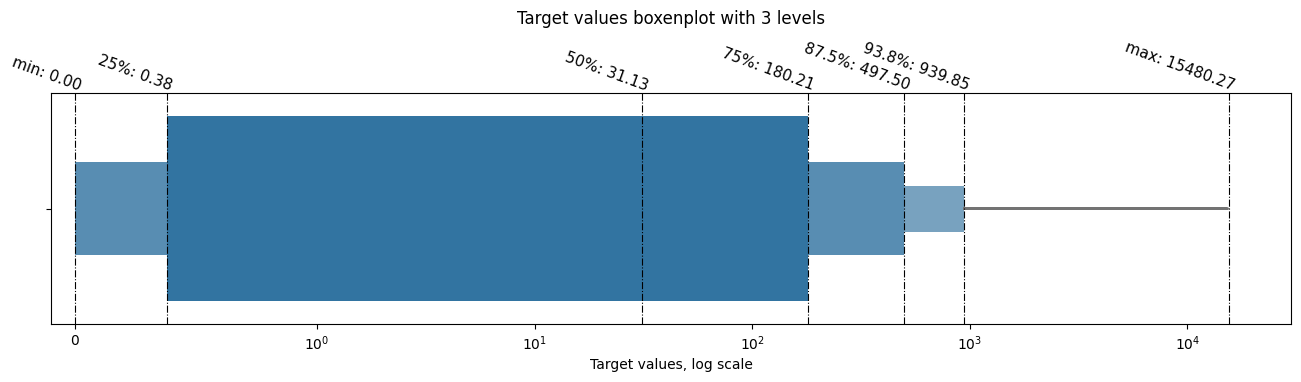

In [177]:
plt.figure(figsize=(16, 3))
# plt.figure(figsize=(12, 5))
ax = sns.boxenplot(
    df,
    x="target",
    linewidth=0,
    # width_method='linear',
    k_depth=levels - 2,
    flier_kws={
        'marker': '.',
        's': .1,
        })

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
plt.vlines(
    levels_values.values,
    ax.get_ylim()[0],
    ax.get_ylim()[1],
    'black',
    'dashdot',
    lw=.8,
)

for ix, l in enumerate(levels_values):
    plt.text(
        levels_values.values[ix],
        ax.get_ylim()[1],
        f'{levels_values.index[ix]}: {levels_values.values[ix]:.2f}',
        fontsize=11,
        rotation=-20,
        ha='right',
        va='bottom',
        transform=mtransforms.offset_copy(
            ax.transData,
            x=8,
            units='dots'),)

ax.set_xlim(-.1, 30_000)
plt.xscale('symlog', linthresh=1)

plt.title('Target values boxenplot with 3 levels', pad=50)
plt.xlabel("Target values, log scale")
plt.show()

- There are only two levels on the left side of the boxenplot (as opposed to three levels on the right side), which means that there are a huge number of identical values that cannot be separated (that is, two different percentiles (25% and 12.5%) will have the same value).

In [181]:
df.target.value_counts().head()

target
0.000    351496
0.001     10733
0.003      6619
0.002      5365
0.004      4593
Name: count, dtype: int64

In [192]:
df.target.count()

2017824

- Null values are the most common and occur in more than 10 percent of cases (351496 / 2017824).

In [110]:
import statsmodels.api as sm
data = sm.datasets.longley.load()
exog = sm.add_constant(data.exog)
# >>> mod_fit = sm.OLS(data.endog, exog).fit()
# >>> res = mod_fit.resid # residuals
# >>> fig = sm.qqplot(res)
# >>> plt.show()

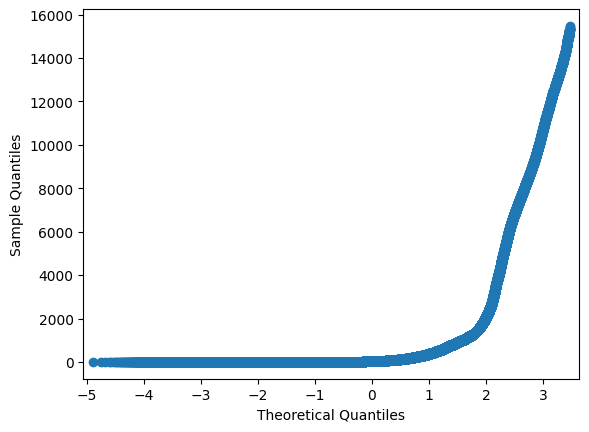

In [113]:
fig = sm.qqplot(df.target)
plt.show()


-
-

In [ ]:
ax = sns.histplot(
    data=df[[
        "county",
        "product_type",
        # "is_business",
        # "is_consumption",
    ]],
    y="county",
    # y='is_consumption',
    hue="product_type",
    multiple='stack',
)

plt.xticks(
    ticks=range(0, int(2.5e5), int(2.5e4)),
    # labels=[f"{i:.2e}" for i in range(0, int(2.5e5), int(2.5e4))],
    rotation=15,
)

# plt.legend(
#     # title="product_type",
#     bbox_to_anchor=(1.005, 1),
#     # loc="upper left",
#     # borderaxespad=0,
#     # markerscale=5,
# )

# ax = sns.histplot(penguins, x="bill_length_mm", hue="species")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(.5, 1),
    ncol=4,
    title='product_type',
    frameon=False,
)
plt.show()

In [ ]:
test = df.groupby([
    "county",
    "product_type",
    "is_business",
    "is_consumption",
], observed=True)['target'].count().reset_index()
# test = test[['county', 'product_type', 'is_business', 'is_consumption']].astype(str)
# test['group'] = test['county'] + test['product_type']
test['group'] = test[['county', 'product_type', 'is_business', 'is_consumption']].astype(str).agg('-'.join, axis=1)
# df["period"] = df[['Courses', 'Duration']].agg('-'.join, axis=1)
# test[['county', 'product_type', 'is_business', 'is_consumption',]] = test[['county', 'product_type', 'is_business', 'is_consumption',]].astype(str)
# test['group'] = test.county.str()
# ) + str(test.product_type) + str(test.is_business) + str(test.is_consumption)
test

In [ ]:
# # test

# from itertools import product
# # original data
# # extract unique categories
# c1 = test.county.cat.categories
# c2 = test.product_type.cat.categories
# c3 = test.is_business.cat.categories
# c4 = test.is_consumption.cat.categories
# # c2 = df.y.cat.categories
# # # make data frame with all possible category combinations
# df_cats = pd.DataFrame(
#     list(product(c1, c2, c3, c4)),
#     columns=['county', 'product_type', 'is_business', 'is_consumption'])
# # # create desired column
# df_cats = df_cats.assign(group=df_cats.county.astype('str') + '-' +
#                          df_cats.product_type.astype('str') + '-' +
#                          df_cats.is_business.astype('str') + '-' +
#                          df_cats.is_consumption.astype('str'))
# # df_cats
# # # join this column to the original data
# df_comb = pd.merge(
#     test,
#     df_cats,
#     how="left",
#     on=["county", "product_type", 'is_business', 'is_consumption'])
# df_comb

In [ ]:
plt.figure(figsize=(19, 2))
sns.barplot(test, x='group', y='target', hue='county', palette=PALETTE,)
plt.xticks(
    # ticks=range(0, int(target_mx) + 1, int(target_mx / bins)),
    rotation='vertical',
    fontsize=8,
    # plt.yticks(fontsize=20)
)
plt.legend(
    title="County",
    bbox_to_anchor=(1.005, 1),
    loc="upper left",
    borderaxespad=0,
    markerscale=5,
)
plt.show()

In [ ]:
# treemap_df = df.copy()
# # treemap_df['is_business'] = treemap_df['is_business'].map({False: 'not_business', 1: 'business'})
# # treemap_df['is_consumption'] = treemap_df['is_consumption'].map({False: 'production', 1: 'consumption'})
# # values_mapper = {
# #     'is_business': {0: False, 1: True},
# #     'is_consumption': {0: False, 1: True},

# fig = px.treemap(
#     treemap_df.sample(10000),
#     path=[
#         px.Constant("county"),
#         "county",
#         "product_type",
#         "is_business",
#         "is_consumption",
#     ],
#     width=1600,
#     height=1500,
#     # branchvalues='remainder'

#     # names="county",
#     # hover_name ='is_business',
#     # values="pop",
#     # color="lifeExp",
#     # hover_data=["iso_alpha"],
#     # color_continuous_scale="RdBu",
#     # color_continuous_midpoint=np.average(df["lifeExp"], weights=df["pop"]),
# )
# fig.update_layout(margin=dict(l=25, r=25, t=25, b=25))
# fig.data[0].textinfo = "label+value"
# fig.show()

In [ ]:
# fig = px.sunburst(
#     df.sample(1000),
#     path=[
#         "county",
#         "product_type",
#         "is_business",
#         "is_consumption",
#     ],
#     width=720,
#     height=720,
#     # names='county',
#     # parents='parent',
#     # values='value',
# )
# fig.update_layout(margin=dict(l=100, r=100, t=5, b=5))
# fig.show()

In [ ]:
rows = 4
cols = 1
categories = ['county', 'is_business', 'product_type', 'is_consumption']

fig, ax = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(12, 15),
)

for ind, column in enumerate(categories):
    plt.subplot(rows, cols, ind + 1)
    data = (df[column].value_counts(
        normalize=True).rename("percentage").mul(100).reset_index().round(2))

    # Rounding for total sum == 100.0
    data['percentage'] = (data['percentage'].transform(lambda x: pd.Series({
        x.index[0]: (100 - x.iloc[1:].sum())
    }).combine_first(x)))

    barplot = sns.barplot(data=data,
                          y=column,
                          x="percentage",
                          hue=column,
                          orient='h',
                          legend=False,
                          palette=PALETTE,)
    for container in barplot.containers:
        barplot.bar_label(
            container,
            fmt=f"%.{2}f",
        )

    # plt.legend('', frameon=False)
    plt.ylabel(
        column,
        rotation=0,
        labelpad=60,
    )

fig.align_ylabels()
plt.show()

# conclusions from BARPLOT

In [ ]:
# sorted_list = [
#     "county",
#     "is_business",
#     "product_type",
#     "is_consumption",
# ]

In [ ]:
# sorted_train = df.sort_values(sorted_list + ['datetime']).copy()

# train_sg = df.sort_values(sorted_list).groupby(sorted_list, observed=True)

# train_sg[['datetime']].apply(lambda x: x.duplicated()).sum()

In [ ]:
# ind = df.copy().dropna().set_index('datetime')

In [ ]:
# df.plot(x='target',)
# df.target.plot(kind='bar')

In [ ]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    s=1,
)

plt.title("Energy consumption and production")
plt.grid(alpha=.3)
plt.show()

- ##### Target has seasonal, weekly and less noticeable montly cycles.

In [ ]:
# Added negative target values for better visualisation

df["modified_target"] = np.where(
    df["is_consumption"] == 1,
    df["target"] * (-1),
    df["target"],
)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.scatterplot(
    data=df,
    x="datetime",
    y="modified_target",
    hue="county",
    palette=PALETTE,
    s=2,
)


plt.title(
    "Energy consumption (below 0) or production (above 0) for each subsegment\
in each hour"
)
plt.legend(
    title="County",
    bbox_to_anchor=(1.005, 1),
    loc="upper left",
    borderaxespad=0,
    markerscale=5,
)

months_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(months_locator)
plt.xticks(rotation=45)
# plt.yscale('symlog')

plt.grid(alpha=.3)
plt.show()

##### 1. The higher target value, the fewer such values. With large values, it becomes easy to distinguish values by county.
##### 2. Maximum electricity consumption and production values are increasing from year to year.
##### 3. Energy production in winter is significantly lower than in summer.
##### 4. Energy consumption in winter is bigger than in summer.
##### 5. During the New Year holidays, there is a decrease in electricity consumption.
##### 6. Harjumaa county has highest individual values of energy consumption (for the entire observation period) and production (for spring-autumn period). Tartumaa has second highest values for the entire observation period except last twelve weeks when and Valgamaa get ahead in enrgy production.

# barplot to check the second point
# Because the data timeline is less than 2 years, not all months can be compared with the corresponding values from the previous year.

In [ ]:
df.sort_values('datetime').iloc[[0, -1]]

# The months are available for comparison from September to May.

In [ ]:
df["month"] = df["datetime"].dt.month.astype("int8")

In [ ]:
descriptive_statistics_second = (
    df
    .query('datetime >= "2022-09-01 00:00:00"')
    .groupby(['month', 'is_consumption',], observed=False)[['target']]
    .describe())

In [ ]:
descriptive_statistics_first = (
    df
    .query('"2021-09-01 00:00:00" <= datetime < "2022-06-01 00:00:00"')
    .groupby(['month', 'is_consumption',], observed=False)[['target']]
    .describe())

In [ ]:
# descriptive_statistics_second.compare(descriptive_statistics_first, keep_equal = True)

In [ ]:
# descriptive_statistics_first

In [ ]:
# descriptive_statistics_second

# Delta in descriptive statistics of target values.

In [ ]:
# Delta in descriptive statistics of target values for months which there is data from several years relative to the first months (from september to may)

In [ ]:
(((descriptive_statistics_second - descriptive_statistics_first)
  / descriptive_statistics_first * 100)
 .fillna(0)
 .round(2)
 .replace([-np.inf, np.inf],'first value is 0')
)
# Numpy values: 0 / 0 = NaN, float / 0 = inf

In [ ]:
# The amount of available data has increased for all cases except March and April when it decreased and May when it did not change.
# Mean values increased for almost all cases except production in March and November when it decreased.
# Standard deviation increased in all cases
# The maximum values increased in all cases, and the minimum values did not change in most cases

In [ ]:
df['datetime'].nunique()

##### There are 15312 unique timestamps in the dataframe.

In [ ]:
# df.groupby(['is_consumption', 'is_business', 'product_type', 'county'])[['target']].count().reset_index()

In [ ]:
df.columns
# 'county', 'is_business', 'product_type', 'target', 'is_consumption',

In [ ]:
df.groupby('is_consumption', observed=False)[['target']].count()
# продажи в разрезе месяца

In [ ]:
categories = ['county', 'is_business', 'product_type', 'is_consumption']
target = 'target'

In [ ]:
test = df.product_type.value_counts(normalize=True).rename("percentage").mul(100).reset_index().round(2)
test['percentage'] = test['percentage'].transform(lambda s: pd.Series({s.index[0]: (100 - s.iloc[1:].sum()).round(2)}).combine_first(s))
test.percentage.sum()
test

In [ ]:
data = df[column].value_counts(normalize=True).rename("percentage").mul(100).reset_index().round(2)
data['percentage'] = data['percentage'].transform(
    lambda s: pd.Series({s.index[0]: (100 - s.iloc[1:].sum())})
    .combine_first(s)
)

In [ ]:

# for ind, column in enumerate(categories):
#     data = df[column].value_counts(normalize=True).rename("percentage").mul(100).reset_index().round(2)
#     data['percentage'] = data['percentage'].transform(
#         lambda s: pd.Series({s.index[0]: (100 - s.iloc[1:].sum())})
#         .combine_first(s)
#     )
#     display(data['percentage'])

In [ ]:
target_percentage = (
    df.target
    .value_counts(normalize=True)
    .mul(100)
    .rename("Percentage")
    .reset_index())

target_percentage

In [ ]:
df.dropna().groupby(['is_consumption', 'datetime'], observed=False)[['target',]].max().query('target < 0')

In [ ]:
(df
 .dropna()
 .set_index(['county'])
 .groupby(['is_consumption', 'datetime'], observed=False)[['target',]]
 .idxmax()
 # .rename('')
)

In [ ]:
testgrp = df.groupby(['is_consumption', 'datetime'], observed=False)[['target',]].idxmin(skipna=True).reset_index()

In [ ]:
testgrp.isna().sum()

In [ ]:
testgrp[testgrp['datetime'] == '2021-09-01 12:00:00']

In [ ]:
df.query('datetime == "2021-09-01 12:00:00" and is_consumption == False').sort_values('target')

In [ ]:
# target_business = sns.relplot(
#     data=df,
#     x="datetime",
#     y="modified_target",
#     col="is_business",
#     hue="county",
#     height = 8,
#     # aspect = 1.6,
#     # size="size",
#     # style="sex",
#     palette=PALETTE,
#     s=1,
# )
# # l = target_business._legend

In [ ]:
sns.relplot(
    data=df,
    x="datetime",
    y="modified_target",
    row='is_business',
    col="product_type",
    hue="county",
    palette=PALETTE,
    s=4,
)

In [ ]:
df.query('is_business == False and product_type == "Combined"')

# conclusions from relpot

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.boxenplot(
    data=df,
    x="county",
    y="target",
    hue="is_consumption",
    # k_depth = 'full'
    # split=True,
    # style='is_business',
)

plt.title(
    "Comparison of energy production and consumption in each county"
)
# plt.legend(
#     bbox_to_anchor=(1.005, 1),
#     loc="upper left",
#     borderaxespad=0,
#     # markerscale=3,
# )

for i in range(df.county.nunique()):
    ax.axvline(
        i -.5,
        color="black",
        alpha=.2
    )

plt.xticks(rotation=45)

plt.yscale('log')
# plt.grid(axis='y',alpha=.2)

plt.show()

In [ ]:
df.columns

# conclusions from boxenplot

In [ ]:
sns.pairplot(
    data=df.sample(100000).drop(columns=['target','data_block_id','row_id','prediction_unit_id',]),
    hue="is_business",
    # markers=["o", "s", "D"],
)

In [ ]:
# Visualization of missing data and zeros using lineplot of the daily average

df_for_mean_day = df.copy()
df_for_mean_day['date'] = df_for_mean_day['datetime'].dt.date

fig = plt.figure(figsize=(18, 10))
ax = sns.lineplot(
    data=(df_for_mean_day
          .groupby(["date", "product_type", "county"],observed=True)["target"]
          .mean()
          .reset_index(name="target")),
    x='date',
    y='target',
    style="product_type",
    hue="county",
    ax=fig.gca(),)
ax.grid()
ax.set_yscale('log')
ax.legend(loc='upper left', bbox_to_anchor=(1.005, 1))
plt.show()

In [ ]:
# result = seasonal_decompose(
#     x=ind.query('is_consumption == 0 and county == 0')['target'],
#     model='additive',
#     period=720,
# )

# result.plot()
# plt.show()

- Visualization of seasonal_decompose

<!-- # result = seasonal_decompose(train_set, model='additive', period=12)  # Assuming seasonality is 24 hours
# trend = result.trend.dropna()
# seasonal = result.seasonal.dropna()
# residual = result.resid.dropna()

# plt.figure(figsize=(12, 8))

# plt.subplot(4, 1, 1)
# plt.plot(train_set, label='Original Series')
# plt.title('Original Series')

# plt.subplot(4, 1, 2)
# plt.plot(trend, label='Trend')
# plt.title('Trend Component')

# plt.subplot(4, 1, 3)
# plt.plot(seasonal, label='Seasonal')
# plt.title('Seasonal Component')

# plt.subplot(4, 1, 4)
# plt.plot(residual, label='Residuals')
# plt.title('Residual Component')

# plt.tight_layout()
# plt.show() -->

In [ ]:
df_for_missing = df.copy()

In [ ]:
df_for_missing['hourstamp'] = ((df_for_missing['datetime'] - df_for_missing['datetime'].min())/pd.Timedelta(hours=1)).astype(int)
df_for_missing[['hourstamp','datetime',]].max()

In [ ]:
df_for_missing['group_index'] = df_for_missing.groupby(sorted_list, observed=True).ngroup()
# df_for_missing

In [ ]:
df_for_missing['group_index'].nunique()

In [ ]:
missmap = np.empty(
    (df_for_missing.hourstamp.max() + 1, df_for_missing['group_index'].nunique(),))
missmap.fill(np.nan)

for obs in df_for_missing.values:
    missmap[int(obs[9]), (obs[10])] = 0 if obs[3]==0 else 1

In [ ]:
fig, ax = plt.subplots(figsize=(22, 80))
sns.heatmap(missmap, cmap='Paired', cbar=False)

In [ ]:
df_consumption = df.loc[df['is_consumption'] == 1].copy()
df_consumption['consumption_index'] = df_consumption.groupby(['county', 'is_business', 'product_type',], observed=True).ngroup()
df_consumption['hourstamp'] = ((df_consumption['datetime'] - df_consumption['datetime'].min())/pd.Timedelta(hours=1)).astype(int)

df_production = df.loc[df['is_consumption'] == 0].copy()
df_production['production_index'] = df_production.groupby(['county', 'is_business', 'product_type',], observed=True).ngroup()
df_production['hourstamp'] = ((df_production['datetime'] - df_production['datetime'].min())/pd.Timedelta(hours=1)).astype(int)

In [ ]:
df_consumption.columns

In [ ]:
misscon = np.empty(
    (df_consumption.hourstamp.max() + 1, df_consumption['consumption_index'].nunique(),))
misscon.fill(np.nan)

for obs in df_consumption.values:
    misscon[obs[10], obs[9]] = 0 if obs[3]==0 else 1

In [ ]:
fig, ax = plt.subplots(figsize=(22, 60))
sns.heatmap(misscon,
            cmap='Paired_r',
            # cmap=sns.diverging_palette(80, 160,),
            cbar=False)

In [ ]:
df[1_500_000:].groupby('datetime')['target'].mean().plot(figsize=(20,10))

In [ ]:
client_df = pd.read_csv("client.csv",)

In [ ]:
client_df

In [ ]:
client_df.info()

In [ ]:
client_df = client_df.astype({
    'product_type': 'category',
    'county': 'category',
    'is_business': 'category',
    'date': "datetime64[ns]",})
client_df.info()

In [ ]:
client_df.date = client_df.date.dt.date

In [ ]:
# df.date = df.datetime.dt.date

In [ ]:
sorted_list

In [ ]:
df = pd.merge(
    df,
    client_df,
    how="left",
    on=["data_block_id",
        "county",
        "is_business",
        "product_type",],
    # validate="m:1"
    # suffixes=('','current_')
)

In [ ]:
df

In [ ]:
df

In [ ]:
df.datetime + pd.Timedelta('2d')

In [ ]:
df
.eic_count.describe()

In [ ]:
df.query('county == 0 and is_business == 0 and	product_type == 1')[['target','eic_count','installed_capacity',]].plot(x='installed_capacity',y='eic_count')

In [ ]:
local_df = df.query('county == 0 and is_business == 0 and product_type == 1')
sns.lineplot(
    data = local_df[:1000][['datetime','target',]],
    x = 'datetime',
    y = 'target',)
sns.lineplot(
    data = local_df[:1000][['datetime','eic_count']],
    x = 'datetime',
    y = 'eic_count',)
# plt.show

In [ ]:
train_sg['datetime'].max().unique()

- Время последнего доступного наблюдения не одинаковое.

In [ ]:
train_sg['datetime'].diff().value_counts(dropna=False)

In [ ]:
train_dif = sorted_train.copy()
train_dif['dif'] = train_sg['datetime'].diff()

In [ ]:
train_dif.loc[train_dif['dif']=='173 days 01:00:00']

In [ ]:
added_target = sorted_train.copy()
added_target['target'] = added_target['target'] + 1e7

In [ ]:
timestamp_start = '2021-09-01'
timestamp_stop = '2022-04-10'
vis_segment = added_target.query(r"county==10 and is_business==1 and product_type==2 and is_consumption==0 and @timestamp_start <=datetime<= @timestamp_stop")

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(
    data=vis_segment,
    x="datetime",
    y="target",)
# plt.xticks(range(0,vis_segment.shape[0]+1,240))
plt.show()

In [ ]:
df.query("county==0 and is_business==1 and product_type==2 and is_consumption==0 and '2021-11-15'<=datetime<='2022-03-19'")

In [ ]:
train_dif.query("county==10 and is_business==1 and product_type==2 and is_consumption==0 and 180<=data_block_id<=205")

In [ ]:
sorted_train.query('county==10 and is_business==1 and product_type==2 and is_consumption==0 and "2022-01-23" <= datetime <= "2022-04-23"')

In [ ]:
train_mm = (
    (train_sg[["datetime"]].max()) -
    (train_sg[["datetime"]].min())) / (train_sg[["datetime"]].count() - 1)

train_mm.datetime.unique()

In [ ]:
train_mm[train_mm['datetime'] == '0 days 01:03:03.867646049']

In [ ]:
sorted_df = df.sort_values(sorted_list + ['datetime'])

In [ ]:
first_df = sorted_df.query('county == 5 and is_business == 1 and product_type == 0 and is_consumption == 0').copy()

In [ ]:
first_df['datetime'].diff().unique()

In [ ]:
first_df['diff'] = first_df['datetime'].diff()
first_df = first_df.reset_index(drop=True)
first_df.loc[first_df['diff'] == '31 days 01:00:00']

In [ ]:
first_df[2926:2931]

In [ ]:
2023-05-31 23:00:00 2021-09-01

In [ ]:
2021-09-01

In [ ]:
train_mm[train_mm['datetime'] == '0 days 03:04:25.377643504']

In [ ]:
last_df = sorted_df.query('county == 14 and is_business == 1 and product_type == 2 and is_consumption == 0').copy()

In [ ]:
last_df['datetime'].diff().unique()

In [ ]:
last_df['diff'] = last_df['datetime'].diff()
last_df = last_df.reset_index(drop=True)
last_df.loc[last_df['diff'] == '76 days 01:00:00']

In [ ]:
last_df[717:724]

In [ ]:
sorted_list = ["county","is_business","product_type","is_consumption",]
test = pd.DataFrame(df
 .sort_values(by=sorted_list)
 .groupby(sorted_list)["datetime"]
 .diff())

In [ ]:
test.loc[test['datetime'] == '31 days 01:00:00']

In [ ]:
df.sort_values(by=sorted_list).loc[462816:462821]

In [ ]:
(df
 .groupby([
     "county",
     "is_business",
     "product_type",
     "is_consumption"])["datetime"].diff())

In [ ]:
(df
 .groupby([
     "county",
     "is_business",
     "product_type",
     "is_consumption"])["datetime"].count()
    - df.groupby(
        ["county", "is_business", "product_type", "is_consumption"]
    )["datetime"].nunique()
).sum()

In [ ]:
(df
 .query("'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'")
 # .sort_values(by=[
 #     "county",
 #     "is_business",
 #     "product_type",
 #     "is_consumption",
 #     "datetime",])
 .head(21))

In [ ]:
df.duplicated().sum()[df.duplicated().sum() != 0]

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    s=1,)

plt.title(
    "Energy consumption and production")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxenplot(
    data=df,
    x="county",
    y="target",
    hue="is_consumption",
    # k_depth = 'full'
    # split=True,
    # style='is_business',
)

plt.title(
    "Comparison of energy production and consumption in each county"
)
# plt.legend(
#     bbox_to_anchor=(1.005, 1),
#     loc="upper left",
#     borderaxespad=0,
#     # markerscale=3,
# )
plt.yscale('log')
plt.show()

In [ ]:
sns.heatmap(
    df.drop([
        "data_block_id",
        "row_id",
        "prediction_unit_id",
        "target_modified"], axis=1)
    .corr(),
    annot=True,
    fmt=".2f",
)

plt.title('Correlation between features and target')
plt.show()

In [ ]:
# px.scatter(df[['datetime', 'modified_target', 'county']], x="datetime", y="modified_target", color='county').show()

In [ ]:
# df = df.copy().set_index("datetime")
df["hour"] = df["datetime"].dt.hour.astype("uint8")
df["day_of_week"] = df["datetime"].dt.day_of_week.astype("uint8")
df["day"] = df["datetime"].dt.day.astype("uint16")
df["week_of_year"] = (
    df["datetime"].dt.isocalendar().week.astype("int8")
)
df["month"] = df["datetime"].dt.month.astype("int8")
df["quarter"] = df["datetime"].dt.quarter.astype("int8")
df["year"] = df["datetime"].dt.year.astype("uint16")

# df["modified_target"] = np.where(
#     df["is_consumption"] == True,
#     df["target"] * (-1),
#     df["target"],
# )

df.info()

In [ ]:
sns.displot(
    data=df,
    x="target",
    hue="is_consumption",
    log_scale=True,
)

plt.title("Target's distribution")
plt.show()

In [ ]:
# target_per_county = (
#     df.groupby(["is_consumption", "county"])[["target"]]
#     .sum()
#     .groupby(level=0)
#     .apply(lambda x: x * 100 / x.sum())
#     .reset_index(level=0, drop=True)
#     .reset_index()
#     .rename(columns={"target": "percentage"})
# )
# target_per_county

In [ ]:
# plt.figure(figsize=(18,6))

# barplot = sns.barplot(
#     data=target_per_county,
#     x="county",
#     y="percentage",
#     hue="is_consumption",
# )

# for container in barplot.containers:
#     barplot.bar_label(
#         container,
#         fmt="%.2f",
#         fontsize=9,
#     )

# plt.show()

In [ ]:
def target_percentage_in_subgroup(
    df: pd.DataFrame, feature: str, broken_down_by: str, target: str
) -> pd.DataFrame:
    df = (
        df.groupby([broken_down_by, feature], observed=True)[[target]]
        .sum()
        .groupby(level=0, observed=True)
        .apply(lambda x: x * 100 / x.sum())
        .reset_index(level=0, drop=True)
        .reset_index()
        .rename(columns={"target": "percentage"})
    )
    return df

In [ ]:
def plot_for_categorical_feature(
    df: pd.DataFrame,
    broken_down_by: str,
    features_list: list[str],
    target: str,
):
    length = len(features_list)
    fig, axs = plt.subplots(
        nrows=length,
        ncols=1,
        figsize=(18, 15),
    )
    fig.tight_layout(pad=5)

    for idx, feature in enumerate(features_list):
        plt.subplot(length, 1, 1 + idx)
        data = target_percentage_in_subgroup(
            df, feature, broken_down_by, target
        )

        barplot = sns.barplot(
            data=data,
            x=feature,
            y="percentage",
            hue=broken_down_by,
        )

        for container in barplot.containers:
            barplot.bar_label(
                container,
                fmt="%.2f",
            )

        plt.title(f"{feature} broken down by {broken_down_by}")
    plt.show()

In [ ]:
plot_for_categorical_feature(
    df,
    "is_consumption",
    ["county", "is_business", "product_type"],
    "target",
)

In [ ]:
# sns.relplot(
#     data=df.loc[df['county'] == 2][["datetime", "target", "is_consumption",'is_business']],
#     x="datetime",
#     y="target",
#     col="is_consumption",
#     height=5,
#     aspect=1.5,
#     hue="is_business",
#     # size="size",
#     # style="sex",
#     # palette=["b", "r"],
#     # sizes=(10, 100),
# )

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
length = 24

sns.lineplot(
    data=[np.sin((2 * i * np.pi / (length))) for i in range(length)],
)
sns.lineplot(
    data=[np.cos(i / (length / 2 / np.pi)) for i in range(length)],
)
# sns.lineplot(
#     data=[np.sin((i * np.pi / 7)) for i in range(length)],
# )
# sns.lineplot(
#     data=[np.tan((i / (len / np.pi)) + np.pi/2 + np.pi/len) for i in range(len)],
# )

# plt.xticks(range(-1, 25))
# plt.yscale('symlog')
plt.grid()
plt.show()

In [ ]:
length = 24
for idx, i in enumerate(zip([round(np.sin((2 * i * np.pi / (length))), 3) for i in range(length)], [round(np.cos((2 * i * np.pi / (length))), 3) for i in range(length)])):
    print(idx, i)

In [ ]:
length = 365
[np.tan((i / (length / np.pi)) + np.pi/2) for i in range(length)]

In [ ]:
list_of_sins = [np.sin(i / (len / 2 / np.pi)) for i in range(len)]
list_of_cos = [np.cos(i / (len / 2 / np.pi)) for i in range(len)]
list_of_tans = [(np.sin(i / (len / 2 / np.pi)))/(np.cos(i / (len / 2 / np.pi)))for i in range(len)]
for i in zip(list_of_sins, list_of_cos, list_of_tans):
    print(i)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# len = 10
sns.lineplot(
    data=hours_list,
    # x="datetime",
    # y="target",
    # s=1,
    # hue="county",
    # style='is_business',
)
# ax.set(title = 'Energy consumption or production for the discrete segment for the hour')
plt.grid()
plt.show()

In [ ]:
# df['hr_sin'] = np.sin(df.hr*(2.*np.pi/24))
# df['hr_cos'] = np.cos(df.hr*(2.*np.pi/24))
# df['mnth_sin'] = np.sin((df.mnth-1)*(2.*np.pi/12))
# df['mnth_cos'] = np.cos((df.mnth-1)*(2.*np.pi/12))

In [ ]:
df.groupby("is_consumption")["target"].min()

In [ ]:
df.isna().sum()[df.isna().sum() != 0]

In [ ]:
df.duplicated().sum()[df.duplicated().sum() != 0]

In [ ]:
df.loc[df.isna().any(axis=1)]

In [ ]:
df.datetime[0]

In [ ]:
train = (train
         .astype({
             "county": "category",
             "is_business": "category",
             "product_type": "category",
             "is_consumption": "category",
             "datetime": "datetime64[ns]",})
         .sort_values(by=[
             "county",
             "is_business",
             "product_type",
             "is_consumption",
             "datetime"]))

In [ ]:
(
    df.query(
        "'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'"
    )
    .sort_values(
        by=[
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "datetime",
        ]
    )
    .head(21)
)

In [ ]:
[df[df.isna().any(axis=1)].datetime.unique()]

In [ ]:
df = df.sort_values(
    by=["county", "is_business", "product_type", "is_consumption", "datetime"]
).interpolate()

In [ ]:
(
    df.query(
        "'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'"
    ).head(21)
)

In [ ]:
sns.displot(
    data=df[["target"]],
    log_scale=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    # hue="county",
    # style='is_business',
    # log_scale=True,
)
plt.show()

In [ ]:
sns.displot(
    data=df[["target", "is_business", "product_type"]],
    x="target",
    # bins=200,
    element="poly",
    hue="is_business",
    col="product_type",
    log_scale=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.show()

In [ ]:
sns.relplot(
    data=df.query("county == 0 and is_business == False"),
    x="datetime",
    y="target",
    col="product_type",
    hue="is_consumption",
)
plt.yscale("log")

In [ ]:
sns.relplot(
    data=df.query("county == 0 and is_business == True"),
    x="datetime",
    y="target",
    col="product_type",
    hue="is_consumption",
)
plt.yscale("log")

In [ ]:
sns.scatterplot(
    data=df.query("county==0 and is_business == True"),
    x="datetime",
    y="target",
    hue="is_consumption",
)

In [ ]:
sns.scatterplot(
    data=df.query("is_business == True and is_consumption == False"),
    x="datetime",
    y="target",
    hue="county",
)

# Feature Engineering

In [ ]:
df = df.copy().set_index("datetime")
df

In [ ]:
df["hour"] = df.index.hour.astype("uint8")
df["day_of_week"] = df.index.day_of_week.astype("uint8")
df["day"] = df.index.day.astype("uint16")
df["week_of_year"] = df.index.isocalendar().week.astype("int8")
df["month"] = df.index.month.astype("int8")
df["quarter"] = df.index.quarter.astype("int8")
df["year"] = df.index.year.astype("uint16")

df["modified_target"] = np.where(
    df["is_consumption"] == True, df["target"] * (-1), df["target"]
)

df.info()

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.scatterplot(
    data=df,
    x="datetime",
    y="modified_target",
    # hue="county",
    # style='is_business',
    # log_scale=True,
)
plt.show()

In [ ]:
sns.displot(
    data=df[["modified_target"]],
    x="modified_target",
    log_scale=True,
)

In [ ]:
sns.relplot(
    data=df.query("county == 0")[
        ["modified_target", "product_type", "is_consumption", "is_business"]
    ],
    x="datetime",
    y="modified_target",
    col="product_type",
    hue="is_business",
    # size="size",
    # style="sex",
    # palette=["b", "r"],
    # sizes=(10, 100),
)
# plt.axhline(y = 10,
#             color = 'r',
#             linestyle = '-',
#            lw=100,)
# plt.xscale('log')
plt.yscale("log")
plt.show()

In [ ]:
df.columns

In [ ]:
sns.scatterplot(
    data=df.query("county == 4 and product_type == 1 and is_business == 1")[
        [
            "modified_target",
            "product_type",
            "is_consumption",
            "is_business",
        ]
    ],
    x="datetime",
    y="modified_target",
)
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
# # plt.figure(figsize=(25, 25))
# plt.show()
# # numeric_only=True

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.scatterplot(
    data=df.query(
        "'2023-01-1 8:00:00' <= datetime <= '2023-01-28 23:00:00' and \
        product_type == 3"
    )[
        [
            "county",
            "modified_target",
            "product_type",
            "is_consumption",
            "is_business",
        ]
    ],
    x="datetime",
    y="modified_target",
    # col = 'product_type',
    # product_type
    style="is_business",
    hue="is_business",
    # aspect = 3,
    # # height = 5,
    alpha=0.5,
)
plt.show()

# county
# is_business
# product_type
# is_consumption

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df_hours[f"tm_{h}h"] = df_hours["modified_target"].shift(h)
df_hours.info()

In [ ]:
for h in i in range(24):
    df[f"tm_{i}h"] = df["modified_target"].shift(i)
df["tm_1h"] = df["modified_target"].shift(1)

In [ ]:
df.shift(periods=1)

In [ ]:
# def add_lags(df):
#     target_map = df['PJME_MW'].to_dict()
#     df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
#     df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
#     df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
#     return df

In [ ]:
df_label = df.astype(
    {
        "county": "category",
        "is_business": "category",
        "product_type": "category",
        "is_consumption": "category",
    }
)
df_label.info()

In [ ]:
df_label = pd.get_dummies(df_label, drop_first=True)
df_label.info()

In [ ]:
df_label.columns

In [ ]:
X = df_label.drop(
    columns=[
        "target",
        "data_block_id",
        "row_id",
        "prediction_unit_id",
        "modified_target",
    ],
    axis=1,
)

y = df_label["modified_target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RAND
)

st = StandardScaler()
X_train_std = st.fit_transform(X_train)
X_test_std = st.transform(X_test)

In [ ]:
def r2_adjusted(
    y_true: np.ndarray, y_pred: np.ndarray, X_test: np.ndarray | int
) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)

    if isinstance(X_test, np.ndarray):
        N_features = X_test.shape[1]
    else:
        N_features = X_test

    #     N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true, axis=0) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true), axis=0) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def huber_loss(
    y_true: np.ndarray | pd.DataFrame,
    y_pred: np.ndarray | pd.DataFrame,
    delta: float = 1.345,
):
    """Функция ошибки Хьюбера"""

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.squeeze().to_numpy()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.squeeze().to_numpy()

    assert len(y_true) == len(y_pred), "Разные размеры данных"
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i]) ** 2
        else:
            huber_sum += delta * (abs(y_true[i] - y_pred[i]) - 0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def logcosh(y_true: np.ndarray, y_pred: np.ndarray):
    """функция ошибки Лог-Кош"""
    return np.sum(np.log(np.cosh(y_true - y_pred)))


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    Root Mean Squared Log Error (RMSLE) metric
    Логарифмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    X_test: np.ndarray,
    name: str = None,
    delta: float = 1.345,
):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()
    df_metrics["model"] = [name]

    df_metrics["MAE"] = mean_absolute_error(y_test, y_pred)
    df_metrics["MSE"] = mean_squared_error(y_test, y_pred)
    df_metrics["Huber_loss"] = huber_loss(y_test, y_pred, delta)
    df_metrics["Logcosh"] = logcosh(y_test, y_pred)
    df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics["RMSLE"] = rmsle(y_test, y_pred)
    df_metrics["R2 adjusted"] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics["MPE_%"] = mpe(y_test, y_pred)
    df_metrics["MAPE_%"] = mape(y_test, y_pred)
    df_metrics["WAPE_%"] = wape(y_test, y_pred)

    return df_metrics

In [ ]:
lr_skl = LinearRegression()
lr_skl.fit(X_train_std, y_train)

In [ ]:
lr_skl_pred = lr_skl.predict(X_test_std)

In [ ]:
skl_m = get_metrics(y_test, lr_skl_pred, X_test_std, name="skl_lr")
skl_m

In [ ]:
df_hours = df_hours[
    [
        "county",
        "is_business",
        "product_type",
        "target",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "modified_target",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
]

In [ ]:
df_hours = df_hours.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_hours):
    train = df_hours.iloc[train_idx]
    test = df_hours.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
    # TARGET = "modified_target"
    TARGET = "target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df[f"t_{h}h"] = df["target"].shift(h)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 30))

sns.heatmap(df_hours.corr(), annot=True, cmap="Blues", fmt=".1f")
# plt.figure(figsize=(25, 25))
plt.show()
# numeric_only=True

In [ ]:
# df = df.sort_index().sort_values(
#     ["county", "is_business", "product_type", "is_consumption"],
#     kind="mergesort",
# )
df.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
a = {}
for i in range(1000):
    x = 0;
    for j in range(20):
        x += np.random.choice([-1,1])
    a[x] = a.get(x, 0) + 1;


sns.barplot(x=list(a.keys()), y=list(a.values()));

In [ ]:
# min(data.keys())
# max(data.keys())
# len(data.keys())
# {k: 0 for (k, 0) in range(min(data.keys()), max(data.keys())) if not in data.keys()}
# {k: v*2 for (k,v) in dict1.items()}
# {key:value for (key,value) in dictonary.items()}
# zip()
data

In [ ]:
data

In [ ]:
# for train_idx, val_idx in tss.split(df):
# print('1 train:', train_idx)
# display(df.iloc[train_idx].tail(5))
# print('1 val:', val_idx)

In [ ]:
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)
df = df.sort_index()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["modified_target"].plot(
        ax=axs[fold],
        label="Training Set",
        title=f"Data Train/Test Split Fold {fold}",
    )
    test["modified_target"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        # 'target',
        "is_consumption",
        # 'data_block_id',
        # 'row_id',
        # 'prediction_unit_id',
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        # 'modified_target',
    ]
    TARGET = "modified_target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

- **county - An ID code for the county.**
- **is_business - Boolean for whether or not the prosumer is a business.**
- **product_type - ID code with the following mapping of codes to contract - types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.**
- **target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.**
- **is_consumption - Boolean for whether or not this row's target is consumption or production.**
- **datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).**
- **data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.**
- **row_id - A unique identifier for the row.**
- **prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.**